## Preparing Environement

In [15]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir)
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)
    
import math
import copy as cp
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import preprocessing

from scipy.cluster import hierarchy
from scipy import stats
from scipy.stats import mstats

import helpers as hlp
%aimport helpers
from external import kMedoids
from IPython.display import display

#printing
pd.options.display.float_format = '{:,.2f}'.format


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load preprocessed data

In [17]:
raw_path = os.path.join(root_dir,"data\\raw\\")
interim_path = os.path.join(root_dir,"data\\interim\\") 
processed_path = os.path.join(root_dir,"data\\processed\\") 

reports_path = os.path.join(root_dir,"reports\\")
models_path = os.path.join(root_dir,"models\\")

raw_file_name ="bnd_product_raw.csv"
clean_file_name = "bnd_product_clean.csv"
z_file_name ="bnd_product_z_clean.csv"

row_headers = ['Product']

product_raw_df = pd.read_csv(interim_path+raw_file_name, sep=';', encoding='utf-8')
product_df = pd.read_csv(interim_path+clean_file_name, sep=';', encoding='utf-8')
product_df_full = pd.read_csv(processed_path+z_file_name, sep=';', encoding='utf-8')

X_z = product_df_full.values[:,1:]



nb_col = X_z.shape[1]
X_pca = PCA(n_components = nb_col).fit_transform(X_z)


product_df_full.head()

Product  08/12/2016  09/12/2016  10/12/2016  11/12/2016  12/12/2016  \
0  GBA001BND060FS       -2.66       -2.66       -2.66       -2.66       -2.66   
1  GBA001BND060SS       -1.65       -1.68       -1.68       -1.61       -1.48   
2  GBA001BND160FS        0.81        0.44        0.32        0.16        0.06   
3  GBA001BND250FS       -1.75       -1.75       -1.75       -1.75       -1.75   
4  GBA001BNR250FS       -1.12       -1.20       -1.20       -1.20       -1.20   

   13/12/2016  14/12/2016  15/12/2016  16/12/2016     ...      09/11/2017  \
0       -2.66       -2.66       -2.66       -2.66     ...           -1.23   
1       -1.22       -1.07       -0.63       -0.84     ...           -1.68   
2       -0.19       -0.09        0.17       -0.14     ...            0.24   
3       -1.75       -1.75       -1.75       -1.75     ...            1.47   
4       -1.20       -1.20       -1.20       -1.20     ...            1.95   

   10/11/2017  11/11/2017  12/11/2017  13/11/2017  14/11/2017  15/11/2017  \
0       -1.47       -1.60       -1.73       -1.88       -2.03       -2.15   
1       -1.68       -1.68       -1.68       -1.68       -1.68       -1.68   
2       -0.01       -0.05       -0.20       -0.14       -0.36        0.09   
3        1.47        1.47        1.47        1.47        1.47        1.47   
4        1.72        1.75        1.68        1.61        1.43        1.54   

   16/11/2017  17/11/2017  18/11/2017  
0       -2.07       -2.10       -2.13  
1       -1.68       -1.68       -1.68  
2        0.44        0.48        0.47  
3        1.47        1.47        1.47  
4        1.70        1.70        1.59  

[5 rows x 347 columns]

# 3. Modeling - Clustering Algorithms
Try out Hierarchical clustering, kMeans and kMedodis  on raw (cleaned) data. Then, plot the PCA to visualize the result of the clustering on the principal components

## Agglomerative - Automated Cut-Off Selection

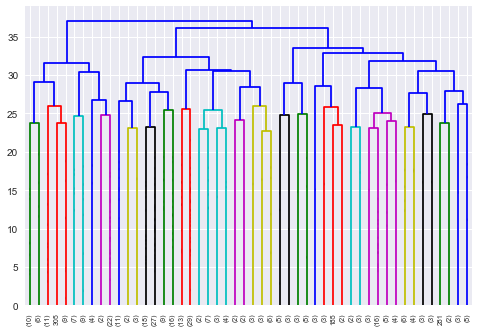

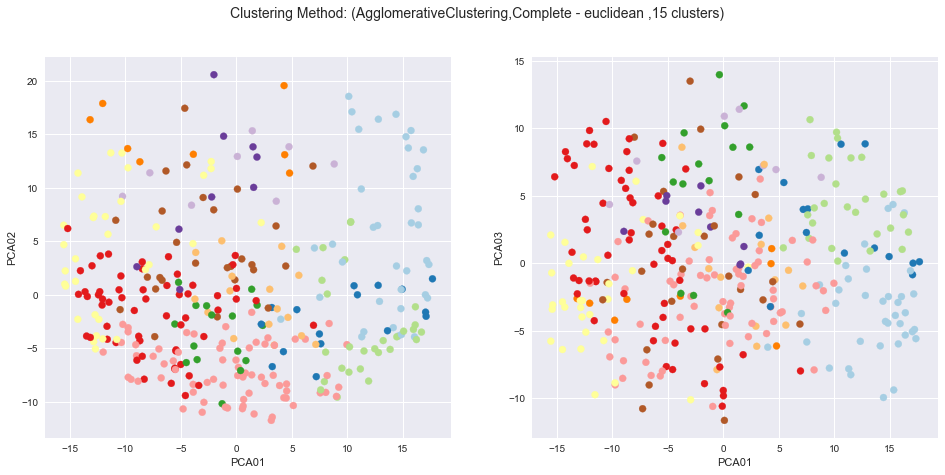

In [4]:
from scipy.cluster import hierarchy

SSE = {}
SILOUHAITE = {}

Z = hierarchy.linkage(X_z, method='complete',metric='euclidean')
dn = hierarchy.dendrogram(Z, truncate_mode='lastp', p=50, leaf_rotation=90., leaf_font_size=7., show_contracted=True)
plt.show()



plt.figure()
labels_h_cc = hierarchy.fcluster(Z, t=15 ,criterion = 'maxclust')
hlp.Clusters_plot(X= X_pca, labels = labels_h_cc,info=["AgglomerativeClustering","Complete - euclidean ","%d clusters"%len(set(labels_h_cc))])


SSE["Agg_complete"] = hlp.getSSE(X_z,X_z[labels_h_cc])

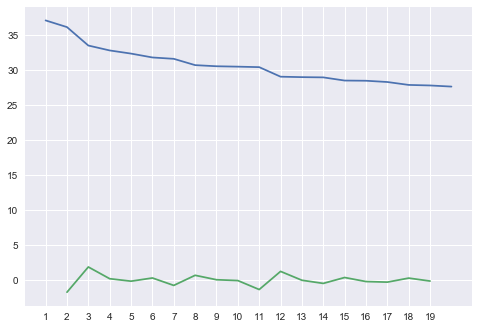

clusters: [ 3  2 12 11  8  7 15 14  6 18  4 17 16  9  5 19 13 10]


In [5]:
last = Z[-20:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.xticks(np.arange(1,len(last)))
plt.show()
best_ks = np.abs(acceleration_rev).argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

### K-Means: Validate different numbers of clusters

clusters: [ 9 22 11 34 30 26 38 40 19 15 13 21 17 28 36 32 24  7]
clusters: [ 4  5  7 11  9 19 17 32 21 15 24 34 26 13 36 38 30 40 22 28]


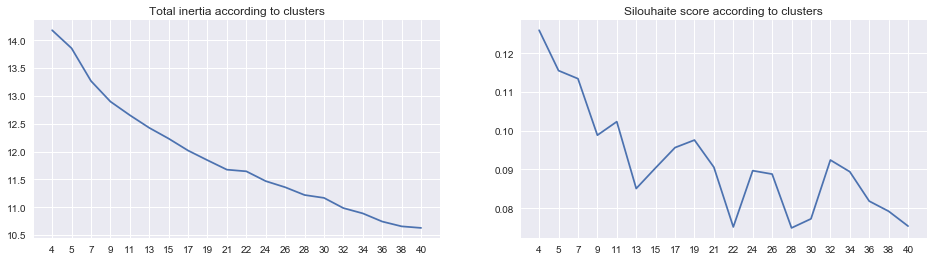

In [6]:
%matplotlib inline
clusters= np.linspace(4,40,20).astype(int)
inertia = []
silouhaite = []
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster).fit(X_z)
    silouhaite.append(hlp.getSilouhaite(X_z,kmeans.labels_))
    inertia += [np.sqrt(kmeans.inertia_/len(kmeans.labels_))]

plt.figure(figsize=(16,4))
    
plt.subplot(1,2,1)
inertia = np.array(inertia)
plt.title("Total inertia according to clusters")    
plt.plot(np.arange(0,len(clusters)),inertia)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)


acc = np.diff(inertia, 2)  # 2nd derivative of the inertia curve
#plt.plot(np.arange(2,len(clusters)), acc)
best_ks = acc.argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:",clusters[k])



plt.subplot(1,2,2)
silouhaite = np.array(silouhaite)
plt.title("Silouhaite score according to clusters")    
plt.plot(np.arange(0,len(clusters)),silouhaite)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)
best_ks = silouhaite.argsort()[::-1]
print("clusters:",clusters[best_ks])


plt.show()


## Ward Clustering

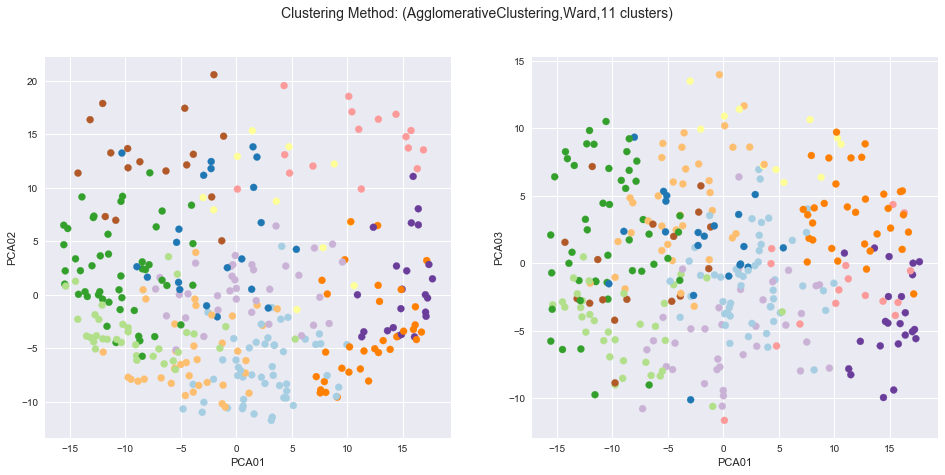

In [7]:
n_cluster = 11

from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward').fit(X_z)
label = ward.labels_

SSE['Ward'] = hlp.getSSE(X_z,X_z[label])
hlp.Clusters_plot(X= X_pca, labels = label,info=["AgglomerativeClustering","Ward","%d clusters"%len(set(label))])

## K-means

In [8]:
%matplotlib inline

kmeans = KMeans(n_clusters=n_cluster).fit(X_z)
label = kmeans.labels_
labels_kmeans = label

SSE["kMeans"] = hlp.getSSE(X_z,X_z[labels_kmeans])

### PCA representation of the clustering

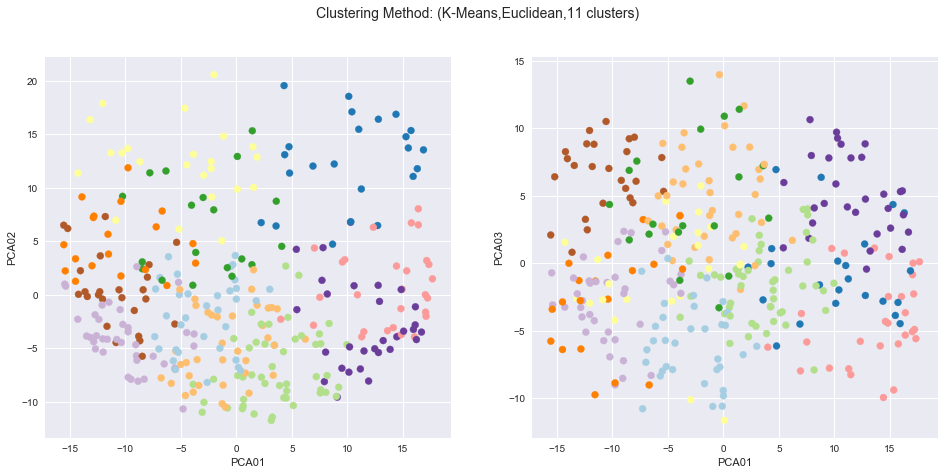

In [9]:
X = X_pca[:,:3]
hlp.Clusters_plot(X= X_pca, labels = label,info=["K-Means","Euclidean","%d clusters"%len(set(label))])

### TSNE representation of the clustering

## Custom Distances

In [11]:
from scipy.stats import spearmanr
def spearmanr_dist(x,y):
    rho, pval = spearmanr(x,y)
    return rho


r,p = spearmanr(X_z)
np.fill_diagonal(r,0)

In [12]:
from external import kMedoids
from scipy.spatial.distance import pdist,squareform

n_obs = X_z.shape[1]
corr_distance = squareform(pdist(X_z, 'correlation'))
euclid_distance = squareform(pdist(X_z, 'euclidean'))
sqcorr_distance = corr_distance**2
#spearman_distance = squareform(pdist(X_z, lambda u, v: spearmanr_dist(u,v)))

## K-medoid: validate number of clusters using silouhaite

[ 5  4  9 13 11 15  7 17 34 24 21 32 22 28 36 30 19 26 38 40]


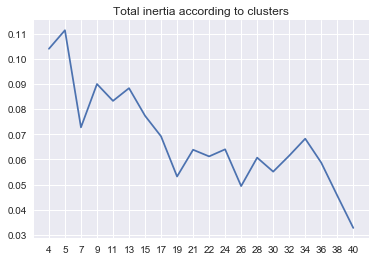

In [13]:
%matplotlib inline
clusters= np.linspace(4,40,20).astype(int)
silouhaite = []
for cluster in clusters:
    labels, medoids = kMedoids.cluster(euclid_distance,k= cluster)
    silouhaite.append(hlp.getSilouhaite(X_z,labels))
    
silouhaite = np.array(silouhaite)
plt.title("Total inertia according to clusters")    
plt.plot(np.arange(0,len(clusters)),silouhaite)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)
best_ks = silouhaite.argsort()[::-1]
print(clusters[best_ks])
plt.show()

## K-medoids (Correlation distance)

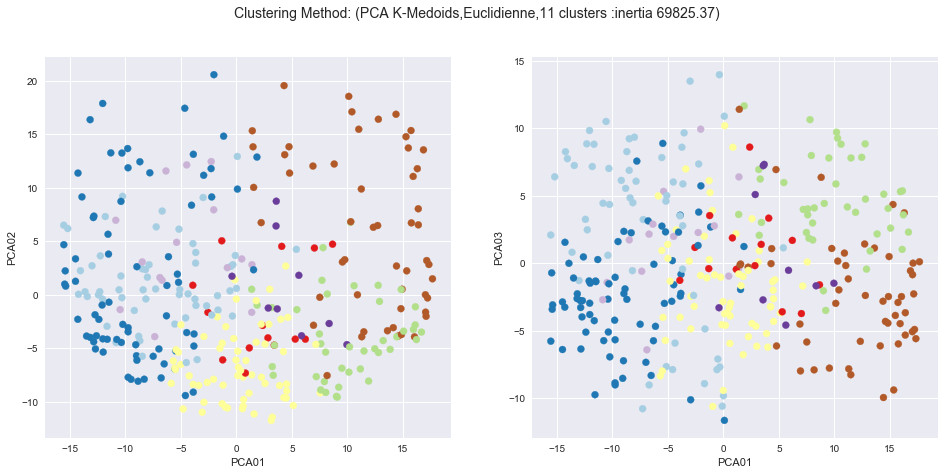

In [14]:
n_cluster = 11
label, medoids_euc = kMedoids.cluster(euclid_distance,k= n_cluster)
labels_kmedoids = label

labels_kmedoids_corr,medoids_corr = kMedoids.cluster(corr_distance,k= n_cluster)
labels_kmedoids_spear,medoids_spear = kMedoids.cluster(corr_distance,k= n_cluster)


SSE["kMedoids"] = hlp.getSSE(X_z,X_z[labels_kmedoids])
SSE["kMedoids_corr"] = hlp.getSSE(X_z,X_z[labels_kmedoids_corr])
SSE["kMedoids_spear"] = hlp.getSSE(X_z,X_z[labels_kmedoids_spear])


SILOUHAITE["kMedoids"] = hlp.getSilouhaite(X_z,labels_kmedoids)
SILOUHAITE["kMedoids_corr"] = hlp.getSilouhaite(X_z,labels_kmedoids_corr)
SILOUHAITE["kMedoids_spear"] = hlp.getSilouhaite(X_z,labels_kmedoids_spear)


hlp.Clusters_plot(X= X_pca, labels = label
                  ,info=["PCA K-Medoids","Euclidienne","%d clusters :inertia %.2f"%(len(set(label)),SSE["kMedoids"])])
#hlp.Clusters_plot(X= X_tsne, labels = label,info=["TSNE K-Medoids","Correlation","%d clusters"%len(set(label))])

## Clustering methods Metrics

In [15]:
for k,v in SSE.items():
    print(" \"%s\" : %.2f"%(k,v))

print()
    
for k,v in SILOUHAITE.items():
    print(" \"%s\" : %.2f"%(k,v))

 "kMedoids" : 69825.37
 "kMeans" : 216560.58
 "Ward" : 201417.62
 "kMedoids_corr" : 71816.89
 "Agg_complete" : 184283.54
 "kMedoids_spear" : 70762.35

 "kMedoids" : 0.09
 "kMedoids_corr" : 0.09
 "kMedoids_spear" : 0.07


# Save Clustering Results

In [63]:
processed_path = "..\\data\\processed\\"
file_name = "p2c1_clustering_clean.csv"

version = 1

file_name = "p2c1_clustering_clean_jour_v%d.csv"%version
models_path = "..\\models\\"

def labels_to_df(labels):
    medoid_cluster_dict = dict()

    for i,l in enumerate(list(set(labels))):
        medoid_cluster_dict[l] = i+1

    groups = list(product_df_full[row_header])
    rows=[]
    for i,g in enumerate(groups):
        m = labels[i]
        rows.append([g,medoid_cluster_dict[m],groups[m]])


    label_df = pd.DataFrame(rows,columns = ["Product Group key","Cluster","Centroid"])
    return label_df




eucl_df = labels_to_df(labels_kmedoids)
corr_df = labels_to_df(labels_kmedoids_corr)
spear_df = labels_to_df(labels_kmedoids_spear)


eucl_df.to_csv(models_path+"euc_"+file_name, sep=';', encoding='utf-8')
corr_df.to_csv(models_path+"corr_"+file_name, sep=';', encoding='utf-8')
spear_df.to_csv(models_path+"spear_"+file_name, sep=';', encoding='utf-8')

In [51]:
print(eucl_df[eucl_df["Cluster"]==8].shape)
eucl_df[eucl_df["Cluster"]==8].sort_values(by=["Product Group key"])

(9, 3)


Product Group key  Cluster        Centroid
12     GBA001JLG200FS        8  GWM007BND090SS
27     GBA003PAM125FS        8  GWM007BND090SS
168    GLV005PAM125FS        8  GWM007BND090SS
200    GWC019SPV500FS        8  GWM007BND090SS
204    GWC026FTG200FS        8  GWM007BND090SS
231    GWG026BND200FS        8  GWM007BND090SS
274    GWM007BND090SS        8  GWM007BND090SS
275    GWM007CAR200FP        8  GWM007BND090SS
296    GWS062BND100SS        8  GWM007BND090SS

# Display Clustering Results

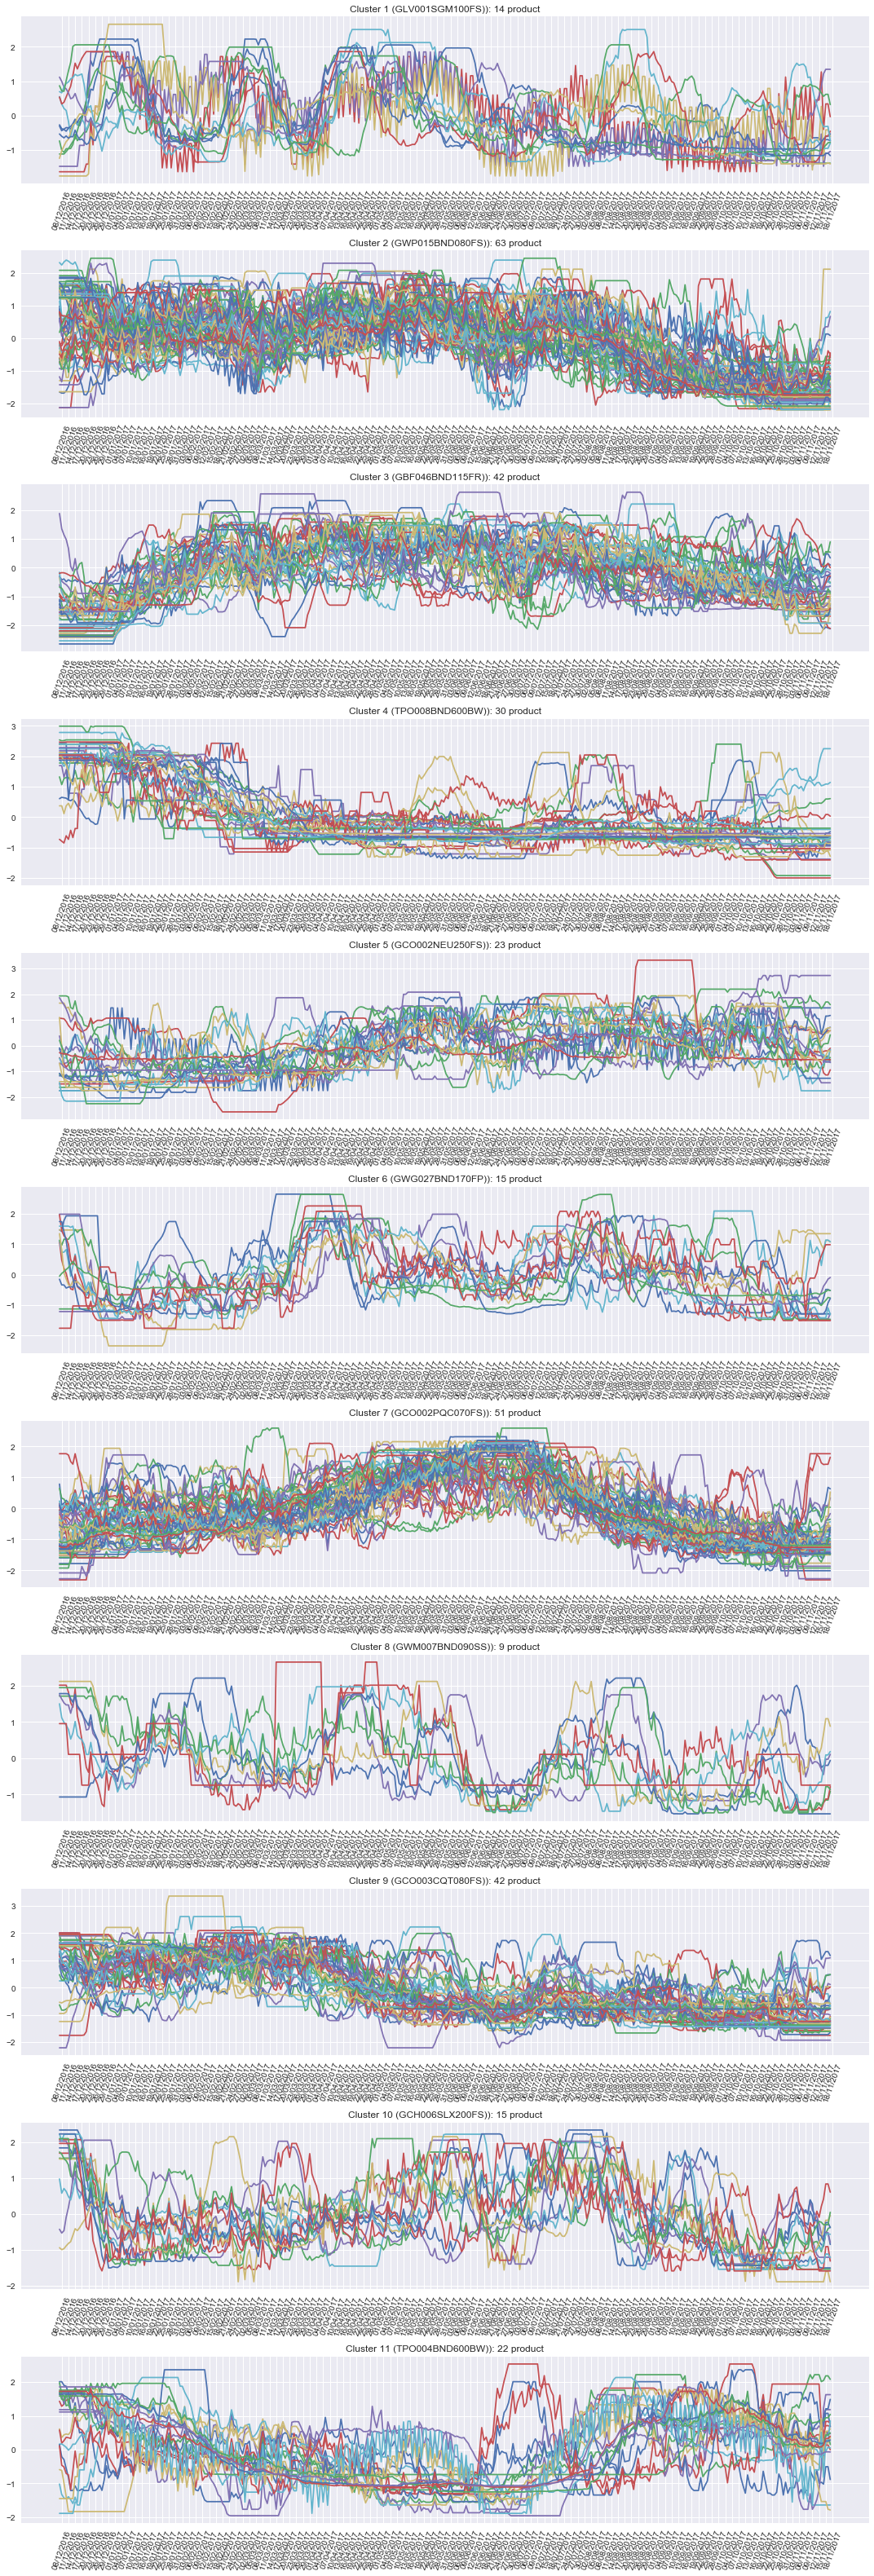

In [60]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = eucl_df)

In [ ]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = corr_df)

In [ ]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = spear_df)

In [ ]:
########################################################################################################################

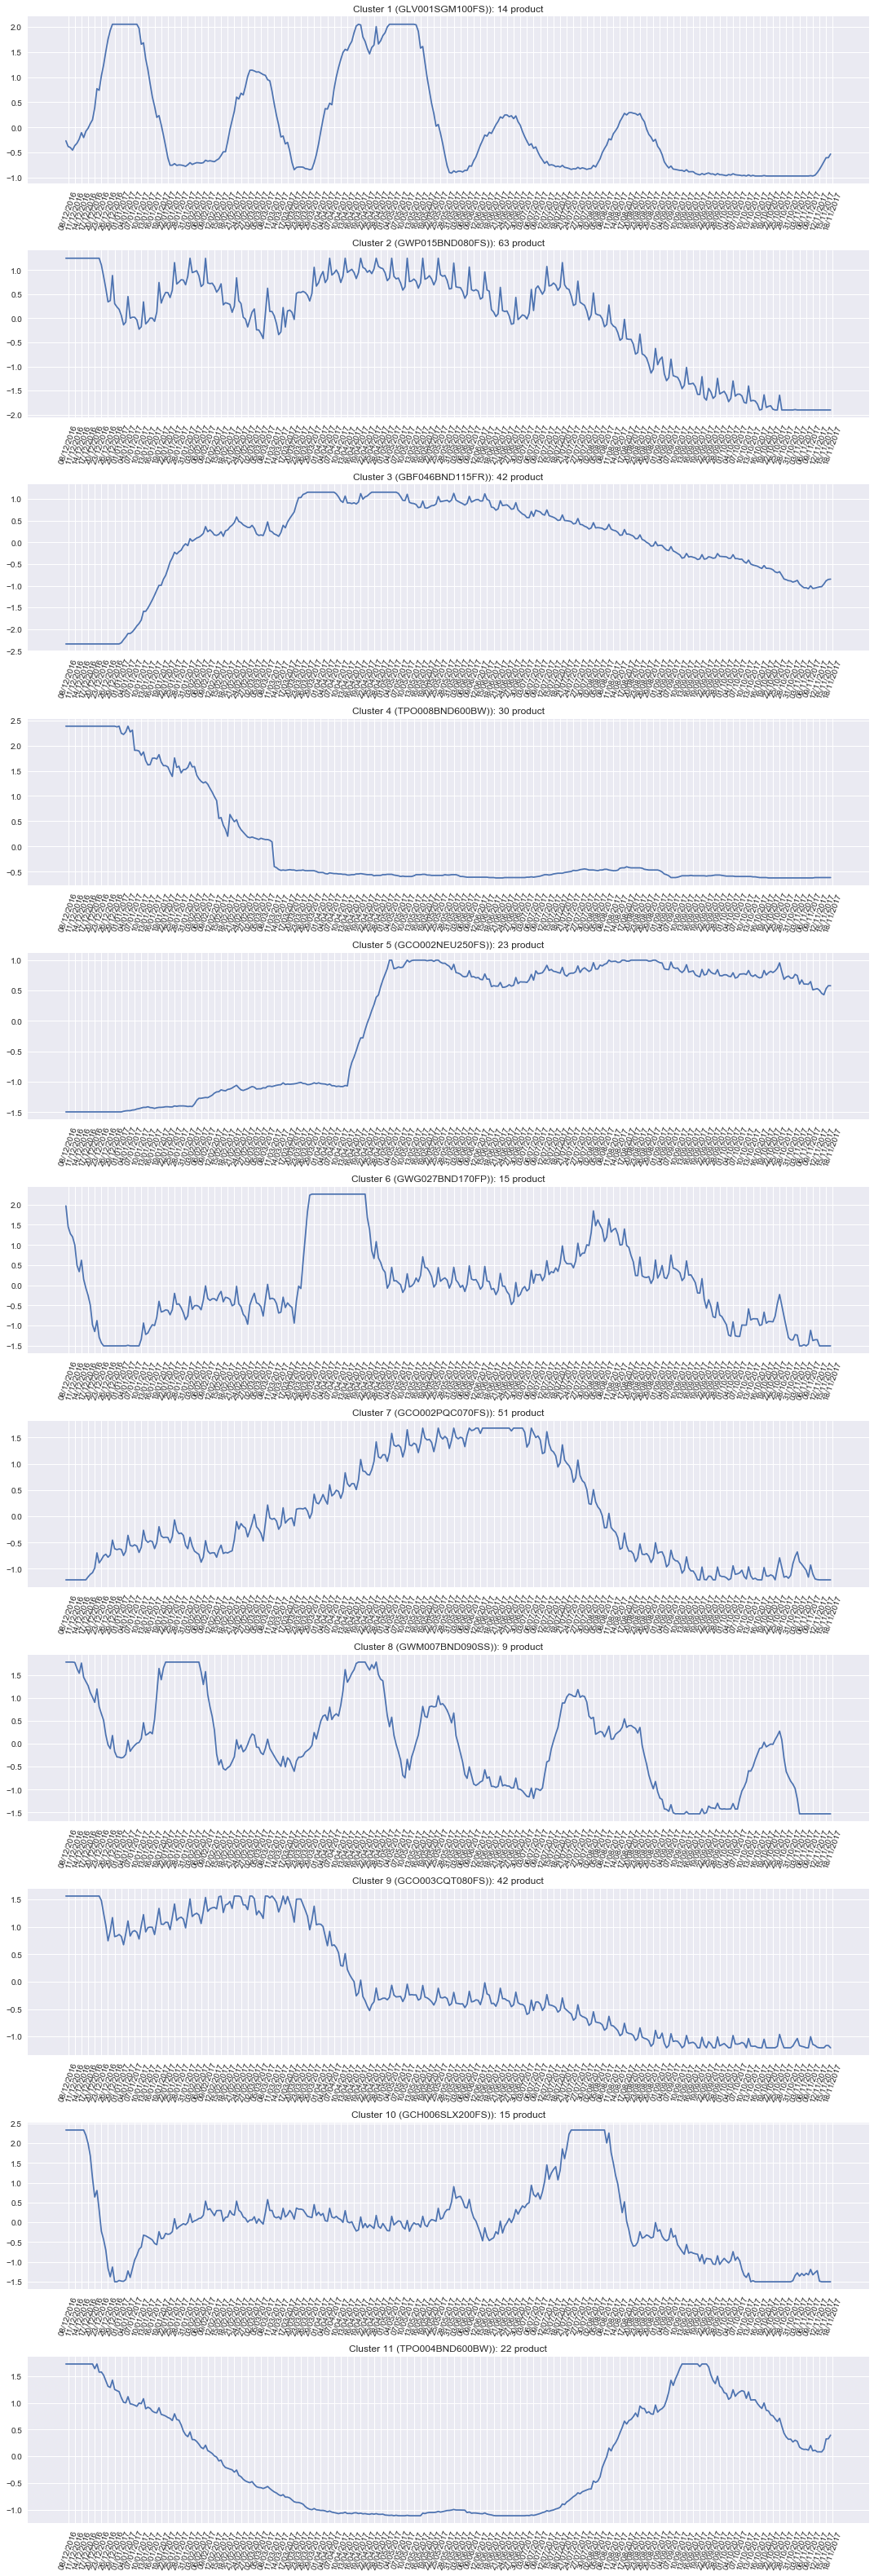

In [61]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = eucl_df,centroid_only = True)

########################################################################################################################

# Other Methods

## BIRCH Algorithm

In [ ]:
label = Birch(n_clusters= n_cluster, threshold=0.5, compute_labels=True).fit_predict(X_z)
labels_birch = label

SSE["Birch"] = hlp.getSSE(X_z,X_z[labels_birch])

hlp.Clusters_plot(X= X_pca, labels = label,info=["PCA BIRCH","(50, 0.5)","%d clusters"%len(set(label))])

## SOM

In [ ]:
from minisom import MiniSom   


som = MiniSom(14, 14, 104, sigma=0.5, learning_rate=0.01) # initialization of 6x6 SOM

som.train_batch(X_z, 1000) # trains the SOM with 100 iterations

# Plotting the response for each pattern in the iris dataset
plt.bone()
plt.pcolor(som.distance_map().T)  # plotting the distance map as background
plt.colorbar()

qnt = som.quantization(X_z)
x,y = som.winner(X_z[0])


plt.show()


# SOM with SOMpy

In [ ]:
import sompy
mapsize = [14,14]
som = sompy.SOMFactory().build(Data1, mapsize, mask=None, mapshape='planar', lattice='rect', normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  
# this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose='info')  # verbose='debug' will print more, and verbose=None wont print anything

# Fuzzy c-means

In [ ]:
import skfuzzy as fuzz

ncenters = n_cluster
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_z.T, ncenters, 2, error=0.005, maxiter=1000, init=None)



labels_fuzzy = np.argmax(u, axis=0)

## Representation methods
### PAA_SAX representation

In [ ]:
from pyts.transformation import PAA,SAX
from pyts.visualization import plot_paa, plot_sax
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
ts = X_z[0].reshape(1,-1)

paa_win = 100
sax_bin = 30


#PAA example
paa = PAA(window_size=None, output_size=paa_win, overlapping=True)
X_paa = paa.transform(ts)
plot_paa(ts[0], window_size=None, output_size=paa_win, overlapping=True, marker='o')

#SAX example
sax = SAX(n_bins=sax_bin, quantiles='gaussian')
X_sax = sax.transform(X_paa)
plot_sax(X_paa[0], n_bins=sax_bin, quantiles='gaussian')
plt.show()

#Extract SAX vector
X_SAX= []
for x in X_z:
    ts = x.reshape(1,-1)
    paa = PAA(window_size=None, output_size=paa_win, overlapping=True)
    X_paa = paa.transform(ts)
    sax = SAX(n_bins=sax_bin, quantiles='gaussian')
    X_sax = sax.transform(X_paa)[0]
    X_SAX.append(list(X_sax))

#Cast back to int
X_SAX = np.array(X_SAX).astype('|S1')
X_SAX = X_SAX.view(np.uint8) - 98
# X_z = X_SAX
# N,M  = X_z.shape
